# Regressione di Poisson con Stan {#sec-stan-poisson-regression}

**Prerequisiti**

Leggi il capitolo 4 di [Beyond Multiple Linear Regression](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html). 

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_poisson_regression"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

In questo tutorial, approfondiremo l'utilizzo di CmdStanPy per condurre un'analisi di [regressione di Poisson](https://it.wikipedia.org/wiki/Regressione_di_Poisson). La regressione di Poisson rappresenta una forma di modello lineare generalizzato impiegato nell'analisi di regressione per modellare dati di conteggio. Essa si basa sull'assunzione che la variabile di risposta Y segua una distribuzione di Poisson, con il logaritmo del suo valore atteso modellabile attraverso una combinazione lineare di parametri sconosciuti.

In questo capitolo, dopo aver investigato il calcolo della media a posteriori e dell'incertezza correlata al tasso di sparatorie fatali da parte della polizia negli Stati Uniti per ogni anno, ci interrogheremo se vi siano evidenze di una tendenza all'aumento di tale tasso nel corso del tempo.

## Introduzione alla Regressione di Poisson

Una variabile casuale di Poisson viene utilizzata per modellare conteggi. Poiché una variabile casuale di Poisson è un conteggio, il suo valore minimo è zero e, in teoria, il massimo è illimitato. L'obiettivo è modellare il parametro principale, λ, il numero medio di occorrenze per unità di tempo o spazio, come funzione di una o più covariate. 

Il modello di regressione di Poisson si basa sulla distribuzione di Poisson, una distribuzione probabilistica che descrive eventi con una probabilità costante di occorrenza in un intervallo di tempo o spazio definito. La funzione di probabilità della distribuzione di Poisson è definita come:

$$ Pr(Y = y) = \frac{\mu^y e^{-\mu}}{y!}, $$

dove $\mu$ rappresenta il numero atteso di eventi nell'intervallo considerato e $y$ i possibili conteggi di eventi, assumendo valori interi non negativi (0, 1, 2, ...). È importante notare che in questa distribuzione, il valore atteso $\mu$ coincide anche con la varianza.

Nel modello di regressione di Poisson, si cerca di collegare il valore atteso di un conteggio, $\mu_i$, a un insieme di variabili esplicative (come età, sesso, sintomi di depressione, ecc.) tramite una relazione funzionale. A differenza dei modelli lineari tradizionali, che possono produrre stime di conteggi negative e quindi non sensate, la regressione di Poisson utilizza una funzione di legame esponenziale per garantire che le stime dei conteggi siano sempre non negative. La relazione è espressa come segue:

$$ \mu_i = e^{\beta_0 + \beta_1 x_i}, $$

dove $\beta_0$ e $\beta_1$ sono i parametri del modello che devono essere stimati. Questi parametri quantificano l'effetto delle variabili esplicative sui conteggi previsti. L'utilizzo della funzione esponenziale come legame assicura che il valore atteso $\mu_i$ sia sempre positivo.

Per costruire il modello di regressione di Poisson:

1. Si assume che il conteggio degli eventi per un dato livello della variabile esplicativa segua una distribuzione di Poisson, con un parametro di tasso ($\mu_i$) specifico per ciascuna osservazione.
2. Si definisce un predittore lineare, $\eta_i$, come una combinazione lineare dei coefficienti del modello ($\beta$) e delle variabili esplicative ($x_i$).
3. Si applica la funzione di legame esponenziale per stabilire che il tasso medio di eventi, $\mu_i$, sia determinato dal predittore lineare, così che $\mu_i = e^{\eta_i} = e^{\alpha + \beta x_i}$.

Questi passaggi consentono di costruire un modello che non solo predice accuratamente i conteggi, ma offre anche insight significativi sull'effetto delle variabili esplicative studiate.

Consideriamo il seguente esempio. Supponiamo di voler studiare il numero medio di episodi di comportamento aggressivo tra adolescenti in una scuola. In questo caso, il parametro $\lambda_i$ rappresenta il numero medio di episodi di comportamento aggressivo per lo studente $i$, e ci aspettiamo di mostrare che la variabilità tra gli studenti di $\lambda_i$ può essere spiegata da variabili come il livello di stress, il supporto familiare, o la presenza di sintomi depressivi. Utilizzando la regressione di Poisson, possiamo modellare il numero medio di episodi di comportamento aggressivo come:

$$ \lambda_i = e^{\beta_0 + \beta_1 \text{Stress}_i + \beta_2 \text{SupportoFamiliare}_i + \beta_3 \text{Depressione}_i}, $$

dove $\beta_0$, $\beta_1$, $\beta_2$ e $\beta_3$ sono i parametri del modello che quantificano l'effetto delle rispettive variabili esplicative sui conteggi di comportamenti aggressivi previsti.

### Assunzioni della Regressione di Poisson

Analogamente alla regressione lineare, l'uso della regressione di Poisson per fare inferenze richiede delle assunzioni sul modello:

1. **Risposta di Poisson**: La variabile di risposta è un conteggio per unità di tempo o spazio, descritta da una distribuzione di Poisson.
2. **Indipendenza**: Le osservazioni devono essere indipendenti l'una dall'altra.
3. **Media = Varianza**: Per definizione, la media di una variabile casuale di Poisson deve essere uguale alla sua varianza.
4. **Linearità**: Il logaritmo del tasso medio, log(λ), deve essere una funzione lineare di $x$.


### Un Esempio con Stan

Per fare un esempio, consideriamo nuovamente i dati corrispondenti alle sparatorie mortale negli Stati Uniti ad opera di agenti di polizia, a partire dal 1° gennaio 2015. 

Importiamo i dati.

In [2]:
url = "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv"
fps_dat = pd.read_csv(url)
fps_dat.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [3]:
# Convert date
fps_dat["date"] = pd.to_datetime(fps_dat["date"])

# Create a new column 'year' to store the year information from the 'date' column
fps_dat["year"] = fps_dat["date"].dt.year

fps_dat.columns

Index(['id', 'date', 'threat_type', 'flee_status', 'armed_with', 'city',
       'county', 'state', 'latitude', 'longitude', 'location_precision',
       'name', 'age', 'gender', 'race', 'race_source',
       'was_mental_illness_related', 'body_camera', 'agency_ids', 'year'],
      dtype='object')

In [4]:
# Filter out rows with year equal to 2024
fps = fps_dat[fps_dat["year"] != 2024]

# Count occurrences of each year in fps
year_counts = fps["year"].value_counts()
print(year_counts)

year
2023    1161
2022    1095
2021    1050
2020    1020
2019     996
2015     995
2018     992
2017     984
2016     959
Name: count, dtype: int64


In [5]:
years = year_counts.index.to_numpy()
year = years - 2019
year

array([ 4,  3,  2,  1,  0, -4, -1, -2, -3], dtype=int32)

In [6]:
counts = year_counts.values
counts

array([1161, 1095, 1050, 1020,  996,  995,  992,  984,  959])

Creiamo un dizionario con i dati nel formato richiesto per CmdStan.

In [7]:
stan_data = {
    "N" : len(year),
    "y" : counts,
    "x" : year 
}
stan_data

{'N': 9,
 'y': array([1161, 1095, 1050, 1020,  996,  995,  992,  984,  959]),
 'x': array([ 4,  3,  2,  1,  0, -4, -1, -2, -3], dtype=int32)}

Compiliamo il modello e stampiamo il codice Stan: 

In [10]:
stan_file = os.path.join(project_directory, "stan", "poisson_regression.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

12:07:11 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/poisson_regression.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/poisson_regression
12:07:21 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/poisson_regression


data {
  int<lower=0> N;  // Numero di osservazioni
  array[N] int<lower=0> y;  // Dati di conteggio (frequenze)
  vector[N] x;  // Variabile predittore (anni, già standardizzata)
}

parameters {
  real alpha;  // Intercetta
  real beta;  // Pendenza
}

model {
  // Priors debolmente informativi
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);

  // Modello di regressione di Poisson
  y ~ poisson_log(alpha + beta * x);
}

generated quantities {
  array[N] int<lower=0> y_pred = poisson_log_rng(alpha + beta * x);
}



Questo modello Stan specifica una regressione di Poisson per dati di conteggio, dove l'obiettivo è modellare il numero di eventi (espressi dalla variabile `y`) in funzione di una variabile predittiva `x` (in questo caso, anni standardizzati). Il modello è strutturato in quattro blocchi principali: `data`, `parameters`, `model`, e `generated quantities`. Ecco una panoramica dettagliata di ciascuna sezione e il suo ruolo nel contesto del modello:

### Blocco `data`
- **N:** Un intero che specifica il numero totale di osservazioni nel dataset. Serve a definire le dimensioni degli array e dei vettori utilizzati nel modello.
- **y:** Un array di interi che rappresenta i dati di conteggio osservati. Ogni elemento in `y` corrisponde al numero di eventi registrati in ciascuna delle `N` unità di osservazione.
- **x:** Un vettore di lunghezza `N` che contiene i valori della variabile predittiva (ad esempio, anni). 

### Blocco `parameters`
- **alpha:** Un parametro reale che rappresenta l'intercetta del modello. In un contesto di regressione di Poisson, `alpha` corrisponde al logaritmo del tasso atteso di eventi quando la variabile predittiva `x` è zero.
- **beta:** Un parametro reale che rappresenta la pendenza o il coefficiente della variabile predittiva `x`. Questo parametro indica come il logaritmo del tasso atteso di eventi cambia in risposta a variazioni di una unità in `x`.

### Blocco `model`
I priors per `alpha` e `beta` sono definiti come distribuzioni normali con media 0 e deviazione standard 10, rappresentando priors debolmente informativi che permettono ai dati di guidare principalmente l'inferenza sui parametri.

Nella tradizionale regressione di Poisson, il parametro $\mu_i$ (il tasso medio di eventi per l'unità osservata) è collegato alle variabili esplicative tramite una funzione esponenziale: $\mu_i = e^{\eta_i} = e^{\beta_0 + \beta_1 x_i}$. Questa trasformazione assicura che il valore predetto di $\mu_i$ sia sempre positivo, indipendentemente dai valori assunti dalle variabili esplicative, una necessità quando si modellano conteggi che non possono essere negativi.

La funzione `poisson_log`, invece di lavorare direttamente con $\mu_i$ come nella forma esponenziale $e^{\eta_i}$, opera sul logaritmo di $\mu_i$. Questo significa che la funzione specifica il logaritmo del tasso medio di eventi come lineare rispetto ai predittori. In altre parole, anziché modellare $\mu_i$ direttamente e poi trasformarlo, si modella il logaritmo di $\mu_i$ (che è $\log(\mu_i)$) come funzione lineare delle variabili esplicative: $\log(\mu_i) = \eta_i = \beta_0 + \beta_1 x_i$.

Questa specificazione ha diversi vantaggi:

- **Stabilità numerica**: Lavorare con il logaritmo di $\mu_i$ può ridurre i problemi di stabilità numerica che talvolta emergono quando si lavora con valori estremamente grandi o piccoli di $\mu_i$.
- **Interpretazione diretta dei parametri**: Poiché si modella il logaritmo di $\mu_i$, i coefficienti (come $\beta_1$) possono essere interpretati in termini di variazione percentuale. Un incremento di una unità in $x_i$ è associato a un moltiplicatore esponenziale di $e^{\beta_1}$ sul tasso medio di eventi.

Nel codice Stan, la linea `y ~ poisson_log(alpha + beta * x);` specifica quindi che i dati di conteggio `y` seguono una distribuzione di Poisson, con il logaritmo del parametro di tasso ($\log(\mu_i)$) modellato come una funzione lineare di `x` attraverso `alpha + beta * x`. 

### Blocco `generated quantities`
- **y_pred:** Un array di interi che contiene valori predetti generati dalla distribuzione di Poisson. Per ogni osservazione, `poisson_log_rng` genera un valore di conteggio casuale basato sul tasso atteso calcolato come `alpha + beta * x`. Questi valori predetti possono essere utilizzati per verifiche predittive posteriori o per ottenere una distribuzione predittiva degli eventi.

Eseguiamo il campionamento.

In [11]:
fit = model.sample(data=stan_data)

12:08:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:08:07 - cmdstanpy - INFO - CmdStan done processing.


Esaminiamo un sommario della distribuzione a posteriori per i parametri.

In [12]:
az.summary(fit, var_names=(["alpha", "beta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,6.934,0.011,6.915,6.955,0.0,0.0,2669.0,2192.0,1.0
beta,0.020,0.004,0.012,0.028,0.0,0.0,4415.0,2727.0,1.0


L'ess_bulk (Effective Sample Size per il bulk dell'estimatore) e ess_tail (Effective Sample Size per la coda dell'estimatore) sono relativamente alti per entrambi i parametri, indicando che il campionamento ha fornito una buona approssimazione della distribuzione a posteriori. Inoltre, il valore di `r_hat` vicino a 1.0 per entrambi i parametri suggerisce che il campionamento ha raggiunto la convergenza, indicando che i risultati sono affidabili.

### Interpretazione del Parametro `alpha`

Il parametro `alpha` è una stima del logaritmo del tasso atteso di eventi (frequenze) quando il valore della variabile esplicativa `x` è zero, ossia quando si trova nella sua media, che in questo contesto è stata standardizzata e centrata sull'anno 2019. Il valore medio di `alpha` è 6.934, indicando che il logaritmo naturale del tasso atteso di eventi quando `x = 0` è circa 6.934.

L'intervallo di alta densità (HDI) del 95% per `alpha` va da 6.912 a 6.954, fornendo un intervallo di stime plausibili per il valore di `alpha` con un alto grado di certezza statistica.

Per interpretare `alpha` in termini di tasso atteso di eventi, usiamo `exp(alpha)`. Questo trasforma il logaritmo del tasso di eventi nel tasso effettivo. Ad esempio, `exp(6.934)` dà il tasso atteso di eventi per l'anno di riferimento 2019.

In [13]:
np.exp(6.934)

1026.5921464104808

### Interpretazione del Parametro `beta`

Il parametro `beta` rappresenta la variazione logaritmica attesa nelle frequenze per ogni incremento unitario in `x` (l'anno, in questo caso). Un valore medio di `beta` pari a 0.020, con un HDI del 95% che va da 0.012 a 0.028, suggerisce una tendenza positiva: all'aumentare degli anni, ci si aspetta un incremento nelle frequenze degli eventi.

Utilizzando il link logaritmico del modello, l'effetto di un incremento di un anno su `x` si traduce in una moltiplicazione del tasso di frequenza per `exp(beta)`. Quindi, un aumento di un anno implica che il tasso di frequenza sarà moltiplicato per `exp(0.020)`, che è approssimativamente 1.02, indicando un aumento previsto del 2% nelle frequenze per ogni anno successivo.

In [14]:
np.exp([0.020, 0.012, 0.028])

array([1.02020134, 1.01207229, 1.02839568])

### Calcolo dell'Aumento Effettivo in Frequenza

Per calcolare l'aumento effettivo in frequenza per ogni anno, utilizziamo la seguente formula:

$$ \text{Aumento atteso} = \exp(\alpha) \times (\exp(\beta) - 1) $$

1. **Calcolo del Fattore di Moltiplicazione:** `exp(beta)` è il fattore di moltiplicazione che descrive come cambia il tasso di frequenza con un incremento di un anno. Con `beta = 0.020`, `exp(beta)` è circa 1.0202.

2. **Determinazione dell'Aumento Attuale in Frequenza:** `exp(alpha)` fornisce il tasso di base delle frequenze quando `x = 0`. Moltiplicando questo tasso di base per `(\exp(\beta) - 1)`, otteniamo l'aumento effettivo in frequenza per ogni anno aggiuntivo. Sottraendo 1 a `exp(beta)`, otteniamo l'incremento percentuale dovuto solamente all'aumento di un anno.

Questa metodologia fornisce un modo intuitivo e statistico per quantificare come le variabili nel tempo influenzano la frequenza degli eventi, permettendo di fare previsioni basate su modelli storici e tendenze osservate.

In [15]:
# Parametri del modello
alpha_mean = 6.934
beta_mean = 0.020

# Calcolo del tasso di frequenza base per l'anno centrato (exp(alpha))
tasso_base = np.exp(alpha_mean)

# Calcolo del fattore di moltiplicazione per l'aumento (exp(beta))
fattore_moltiplicazione = np.exp(beta_mean)

# Aumento atteso in frequenza per un anno
aumento_atteso = tasso_base * (fattore_moltiplicazione - 1)
aumento_atteso

20.738537018435174

Basandosi sul modello di regressione di Poisson, si stima un incremento medio di circa 20.74 nel numero di sparatorie fatali da parte della polizia negli Stati Uniti per ogni anno aggiuntivo. In altre parole, il modello prevede che, anno dopo anno, il numero di tali incidenti potrebbe crescere di circa 21 casi. Questa previsione riflette una dinamica esponenziale tra il passare degli anni e l'aumento della frequenza assoluta di sparatorie fatali, come evidenziato dai dati analizzati.

### Posterior-Predictive Check

Esaminiamo il posterior-predictive check per il modello esaminato:

In [16]:
y_observed = stan_data["y"]

idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive='y_pred',
    observed_data={'y': y_observed}
)

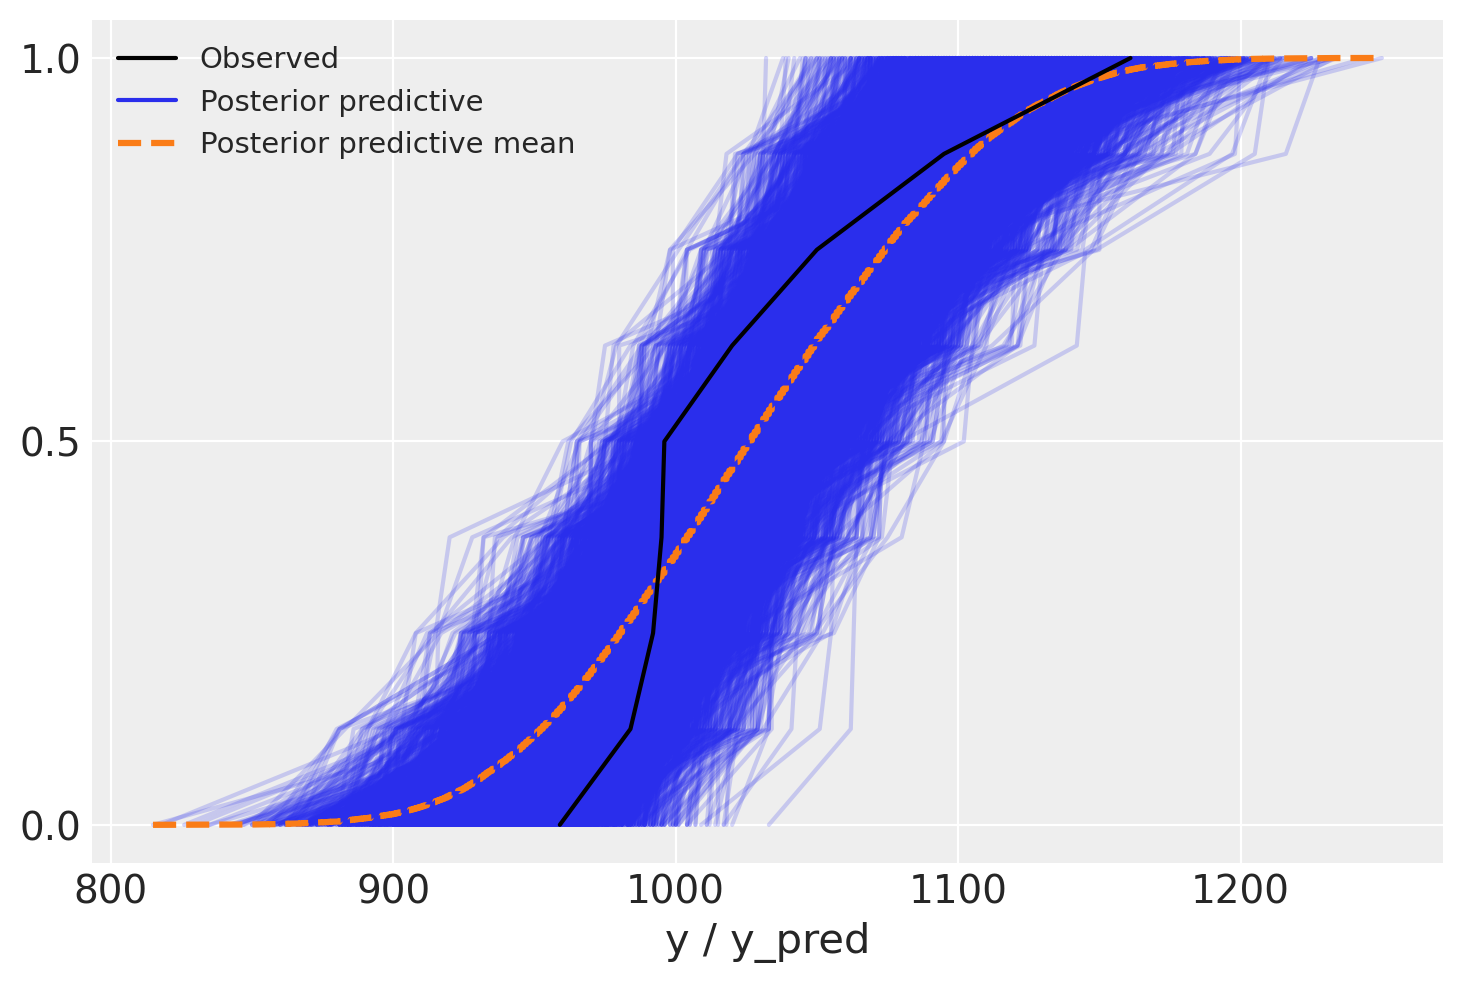

In [18]:
_ = az.plot_ppc(idata, data_pairs={'y': 'y_pred'}, kind='cumulative')

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.14.0
numpy     : 1.26.4
matplotlib: 3.9.1
pandas    : 2.2.2
arviz     : 0.18.0
seaborn   : 0.13.2

Watermark: 2.4.3

